In [1]:
import noise
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import matplotlib.patches as patches
import random
%matplotlib inline

In [2]:
x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0,2*np.pi,np.pi/50)
ynew = interpolate.splev(xnew, tck, der=0)

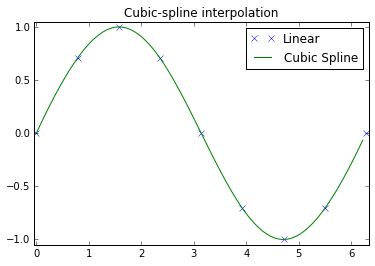

In [3]:
plt.figure()
plt.plot(x, y, 'x', xnew, ynew)
plt.legend(['Linear', 'Cubic Spline'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')


In [4]:
def draw_derivate(x, tck):
    y =  interpolate.splev(x, tck)
    der_value = interpolate.splev(x, tck, der=1)
    dx = 0.2
    newx = [x-dx, x+dx]
    newy = [y-dx*der_value, y+dx*der_value]
    plt.plot(newx, newy, 'r-', lw=2)
    plt.plot(x, y, 'rx',)
    


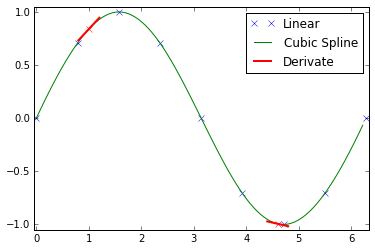

In [5]:
plt.plot(x, y, 'x', xnew, ynew)
draw_derivate(1, tck)
draw_derivate(4.6, tck)
plt.legend(['Linear', 'Cubic Spline', 'Derivate'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.show()

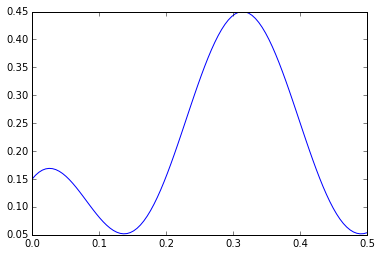

In [6]:
terrainx =  np.linspace(0, 0.5, 30)
terrainy = 0.3*(np.sin(terrainx*5) + 0.5*np.cos(terrainx*20))
tck = interpolate.splrep(terrainx, terrainy, s=0)
tckx = np.linspace(0, 0.5, 100)
tcky = interpolate.splev(tckx, tck)
plt.plot(tckx, tcky)
plt.show()

In [7]:
def plot_3d_surface_multi_azim(X, Y, Z, xlab="", ylab="", zlab="", **kwargs):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1,5):
        ax = fig.add_subplot(2,2, i, projection='3d')
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_zlabel(zlab)
        ax.plot_surface(X, Y, Z, **kwargs)
        ax.view_init(azim=20 + 90*i)
    plt.show()
    

In [8]:
range(1,4)

[1, 2, 3]

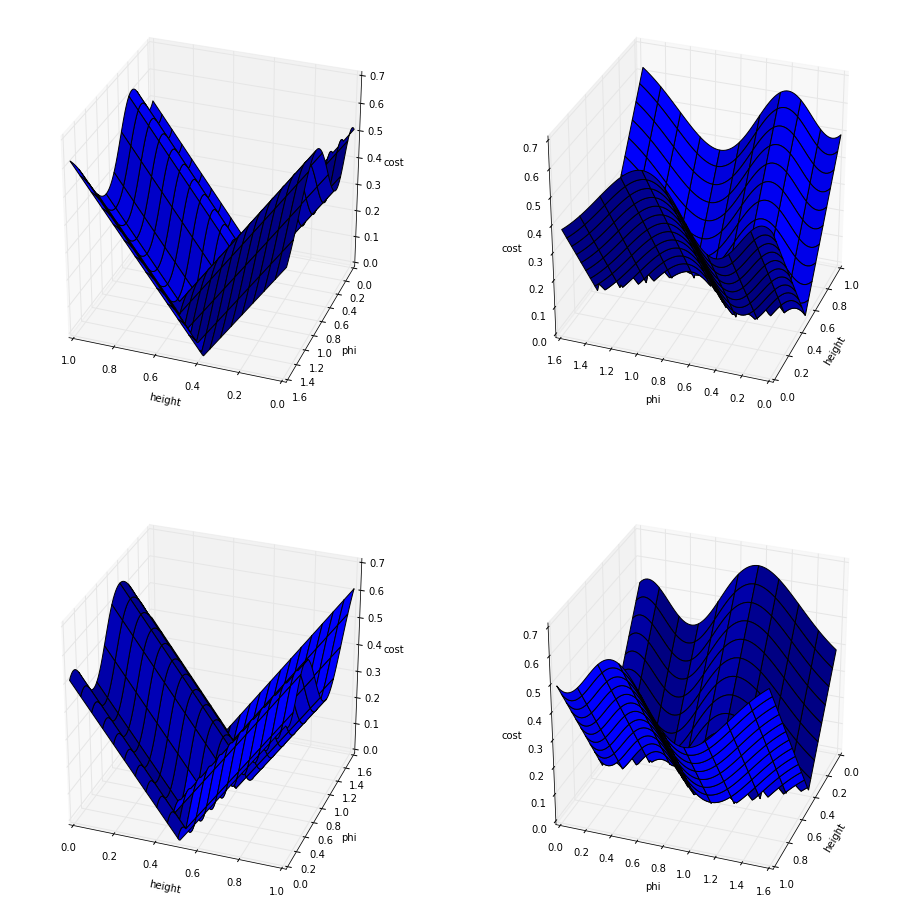

In [9]:
phi = np.linspace(0, np.pi/2, 100)
h = np.linspace(0, 1, 200)
arm_length = 0.36
X, Y = np.meshgrid(h, phi)
cost = lambda height, angle: np.abs(height - arm_length*np.cos(angle) -  interpolate.splev( arm_length*np.sin(angle), tck))
zs = np.array([cost(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

plot_3d_surface_multi_azim(X, Y, Z, xlab="height", ylab="phi", zlab="cost")

In [10]:
#min_index = np.argmin(Z)
#h_min =  X.ravel()[min_index]
#phi_min =  Y.ravel()[min_index]
#plt.plot(tckx, tcky)
#min_point = (np.sin(phi_min)*arm_length, h_min-arm_length*np.cos(phi_min))
#plt.plot(min_point[0], min_point[1], 'ro', markersize=3)
#arm_begin = (min_point[0] - arm_length*np.sin(h_min), min_point[1] + arm_length*np.cos(h_min) )
#plt.plot([min_point[0], arm_begin[0]], [min_point[1], arm_begin[1]], 'r-', markersize=3)
#plt.show()

It's hard to use the optimization approach because requirements regarding the arm-terrain collision cannot be written easily.
let's try with the discrete iterative method

In [31]:
def draw_rect(ax, x, y, w, h):
    ax.add_patch(
    patches.Rectangle(
        (x, y),   # (x,y)
        w,          # width
        h,          # height
        fill=False
        )
    )
def draw_heightmap(ax, x, y):
    dx = np.abs(x[1] - x[0])
    for i in range(0, len(x)):
        top_n = np.floor(y[i]/dx)
        for n in range(0, int(top_n)):
        #for n in range(0, 4):
               draw_rect(ax, dx*i, n*dx, dx, dx)
        draw_rect(ax, dx*i, top_n*dx, dx, (y[i]-top_n*dx))

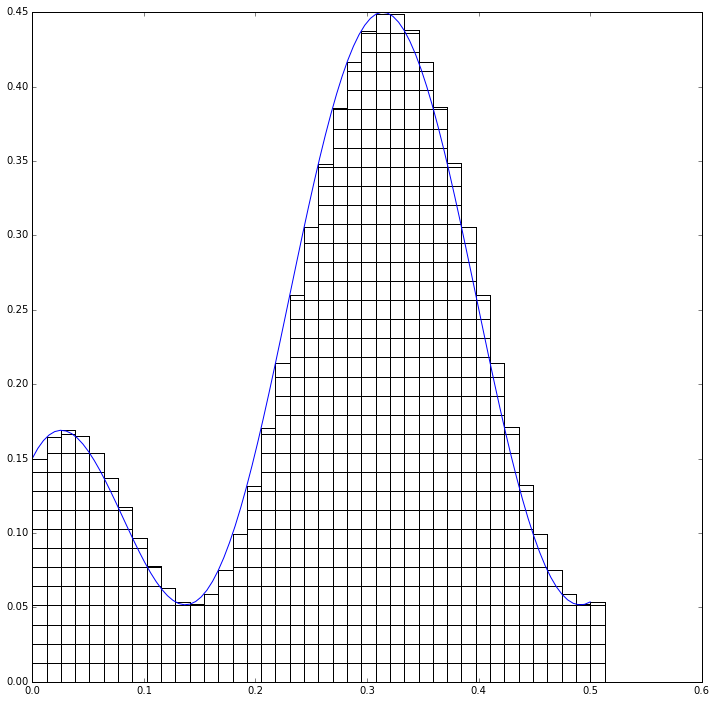

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
heightmapx = np.linspace(0, 0.5, 40)
heightmapy = interpolate.splev(heightmapx, tck)
draw_heightmap(ax, heightmapx, heightmapy)
plt.plot(tckx, tcky)
#plt.axis([0, 3, 0, 3])
plt.show()

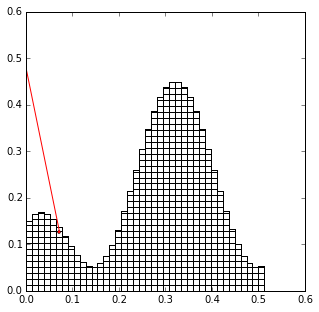

In [13]:
def find_theta(height, hmap_x, hmap_y, eps=0.05):
    thetas = np.linspace(0.1, np.pi/2, 1000)
    dx = np.abs(hmap_x[1] - hmap_x[0])
    for th in thetas:
        x = arm_length * np.sin(th)
        i = int(np.floor(x / dx))
        y = height - arm_length * np.cos(th)
        e = np.abs(hmap_y[i] - y)
        if e < eps:
            testx = np.arange(0, i)*dx
            cotan_th = 1/np.tan(th)
            A = (- testx*cotan_th + height)
            B = hmap_y[0:i] 
            tests =  A  > B
            if np.alltrue(tests):
                #print("Solution for height {} is {} - eps: {} ".format(height, th, e))
                #print("x is {}  y is {} - i : {} ".format(x, y, i))
                return th
    return -1

def draw_leg(height, theta):
    end_point = (np.sin(theta)*arm_length, height-arm_length*np.cos(theta))
    plt.plot(end_point[0], end_point[1], 'ro', markersize=3)
    plt.plot([0, end_point[0]], [height, end_point[1]] , 'r-', markersize=3)
    
def draw_one_leg_solution_for_height(height, hmap_x, hmap_y, eps=0.05):
    theta = find_theta(height, hmap_x, hmap_y, eps)
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.axis([0, 0.6, 0, 0.6])
    draw_heightmap(ax, heightmapx, heightmapy)
    if theta > 0:
        draw_leg(height, theta)
    else:
        print("not found for height " + str(height))


draw_one_leg_solution_for_height(0.48, heightmapx, heightmapy, eps=0.01 )

In [14]:
def draw_one_leg_solution(hmap_x, hmap_y, eps=0.05):
    min_height = max(np.min(hmap_y), 0.1)
    heights = np.linspace(min_height, np.max(hmap_y)+arm_length, 100)
    heights = heights[::-1]
    theta = -1
    for height in heights:
        theta = find_theta(height, hmap_x, hmap_y, eps)
        if theta >= 0:
            break
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.axis([0, 0.6, 0, 0.6])
    draw_heightmap(ax, heightmapx, heightmapy)
    if theta > 0:
        print("solution found: height {} - theta {}".format(height, theta))
        draw_leg(height, theta)

solution found: height 0.651159676282 - theta 0.961277128303


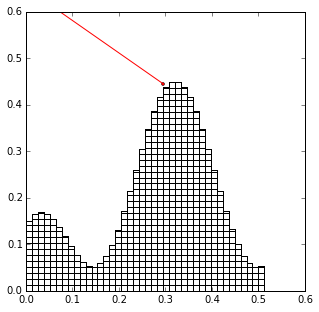

In [15]:
draw_one_leg_solution(heightmapx, heightmapy, eps=0.01)

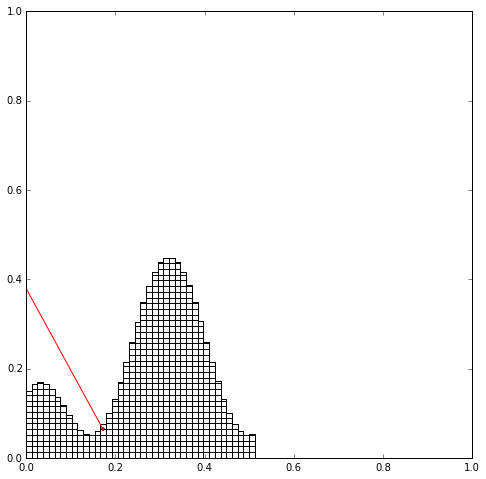

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca() 
ax.axis([0, 1, 0, 1])
draw_heightmap(ax, heightmapx, heightmapy)
draw_leg(0.38, 0.5 )

In [17]:
def gen_rand_heightmap():
    ph = random.random()*np.pi/2
    m1 = 0.3 + 0.5*random.random() 
    m2 = 0.1+ 0.3*random.random() 
    m3 = 0.01*random.random() 
    f1 = 3 + random.random() * 5
    f2 = 10 * random.random()*6
    f3 = 10 * random.random()*15
    terrainx =  np.linspace(0, 0.5, 30)
    terrainy = 0.2 * ( np.abs(m1*(np.sin(terrainx*f1+ph) + m2*np.cos(terrainx*f2) + m3*np.cos(terrainx*f3))) )
    return terrainx, terrainy
def plot_rand_terrain():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    heightmapx, heightmapy = gen_rand_heightmap()
    ax.axis([0, max(heightmapx), 0, max(heightmapy)+0.1])
    draw_heightmap(ax, heightmapx, heightmapy)

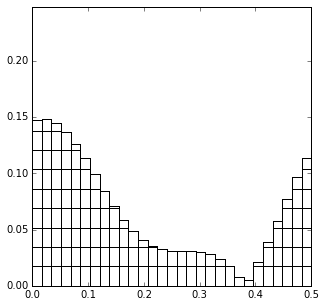

In [18]:
 plot_rand_terrain()

solution found: height 0.449720193852 - theta 0.292867185996


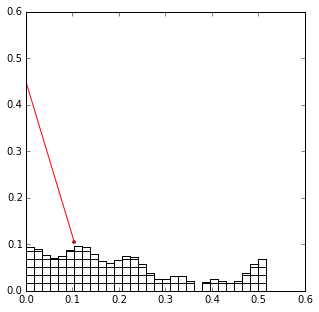

In [19]:
heightmapx, heightmapy = gen_rand_heightmap() 
draw_one_leg_solution(heightmapx, heightmapy, eps=0.01)

In [20]:
def draw_legs_solution(heightmaps, eps=0.05):
    min_height = [np.min(hmap[1]) for hmap in heightmaps]
    min_height = min(min_height)
    max_height =  [np.max(hmap[1]) for hmap in heightmaps]
    max_height = max(max_height)
    max_height = max(max_height, arm_length)
    heights = np.linspace(min_height, np.max(hmap[1])+arm_length, 100)
    heights = heights[::-1]
    thetas = []
    sol_found = False
    for height in heights:
        thetas = np.array([find_theta(height, hmap[0], hmap[1], eps) for hmap in heightmaps])
        if np.alltrue(thetas > 0):
            sol_found = True
            break
    fig = plt.figure(figsize=(10, 10))
    for i in range(0, 4):
        hmap = heightmaps[i]
        ax = fig.add_subplot(2,2, i+1)
        ax.set_title("leg {} theta: {} ".format(i, np.rad2deg(thetas[i])))
        ax.set_ylabel("height (m)")
        ax.axis([0, 0.6, 0, 0.6])
        draw_heightmap(ax, hmap[0], hmap[1])
        if sol_found > 0:
            draw_leg(height, thetas[i])


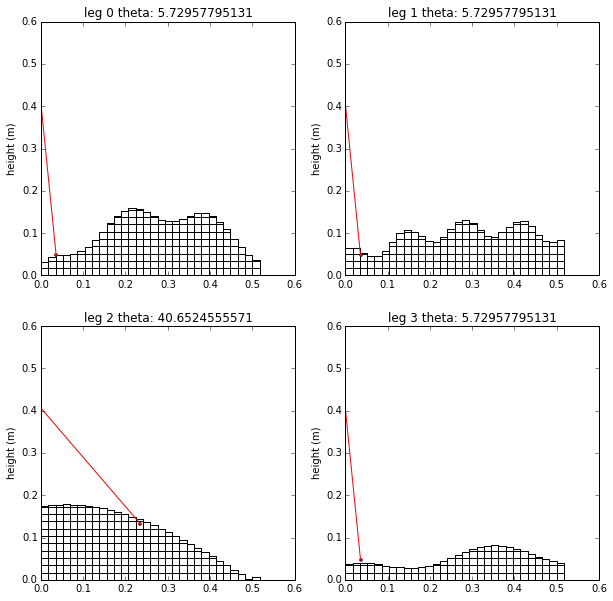

In [21]:
heightmaps = [gen_rand_heightmap() for i in range(0, 4)]
draw_legs_solution(heightmaps, eps=0.01)

In [22]:
import noise
from matplotlib import cm

In [54]:
size=(2, 2)

def create_map(octave=1, persistence=0.5, lacunarity=2.0, z_scale = 1):
    octave = float(octave)
    x = np.linspace(-size[0]/2, size[0]/2, 40)
    y = np.linspace(-size[1]/2, size[1]/2, 40)
    x, y = np.meshgrid(x, y)

    z = np.zeros(x.shape)
    rand=int(random.randint(1, 1000))
    for (x1, y1), _ in np.ndenumerate(z):
        freq=1./30
        z[x1-1, y1-1] = noise.snoise3(x1*freq, y1*freq, rand, int(octave), persistence, lacunarity)
    z = z_scale*z  
    z = z-np.min(z)

    return (x, y, z)
def plot_3d_rand_map(map3d):
    plot_3d_surface_multi_azim(map3d[0], map3d[1], map3d[2], xlab="x", ylab="y", zlab="height (m)", cmap=cm.coolwarm, rstride=1, cstride=1)
def plot_3d_rand_map_2d(map3d):
    plt.imshow(map3d[2], extent=(map3d[0].min(), map3d[0].max(), map3d[1].min(), map3d[1].max()))
    plt.colorbar() 

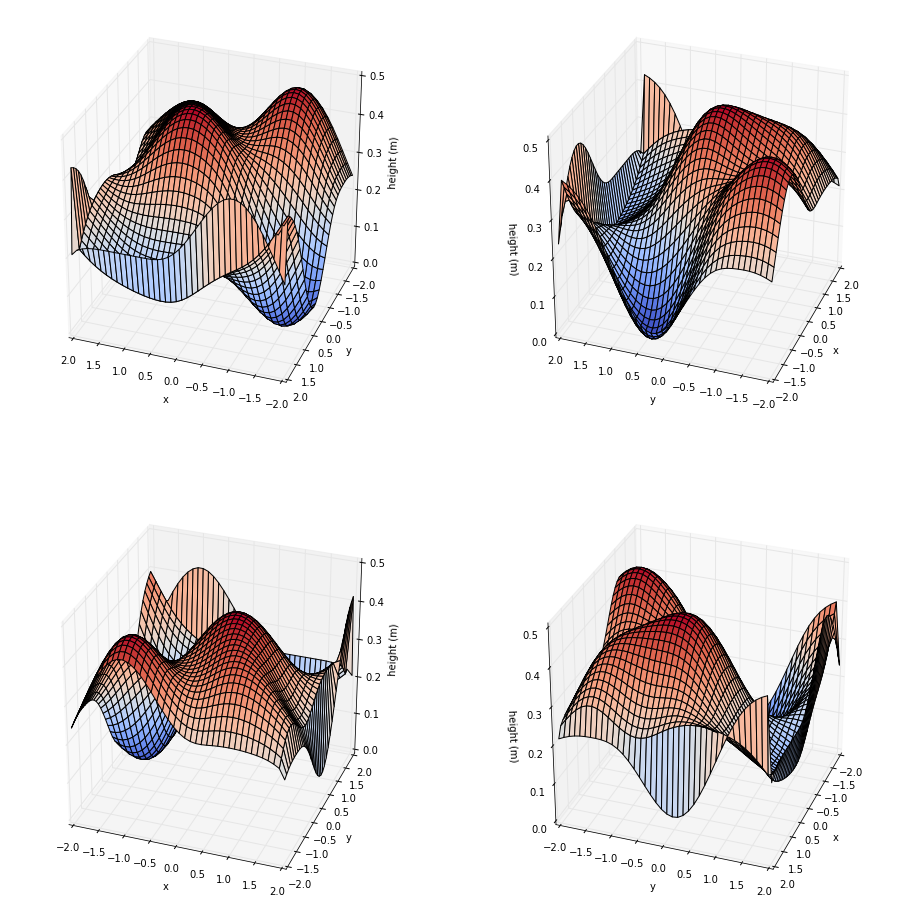

In [33]:
map3d = create_map(octave=1, persistence=1, lacunarity=2, z_scale=0.25)
plot_3d_rand_map(map3d)

In [26]:
def get_terrain_heightmaps_1d(heighmap3d, sample=50):
    # sample the 3d map where the 4 rover's leg can located
    hspace = 0.7
    vspace = 0.6     
    leg_params = [ 
    #      x_rel ,         y_rel,   direction
          (hspace/2, vspace/2, 1),  
          (-hspace/2, vspace/2, 1),  
          (hspace/2, -vspace/2, -1),  
          (-hspace/2, -vspace/2, -1),  
                 ]  
    hmap_2d = []
    for par in leg_params:
        begin = ( par[0], par[1])
        end = (par[0], par[1]+0.5*par[2])
        x =  np.repeat(begin[0], sample)
        y = np.linspace(begin[1], end[1], sample)
        dx = heightmap3d[0][0][1] -  heightmap3d[0][0][0]
        dy = dx
        mx = np.round(x/dx).astype(int)
        my = np.round(y/dy).astype(int)
        heightmapz = np.zeros(my.size)
        for i in range(0, my.size):
            heightmapz[i] = heightmap3d[2][mx[i]][my[i]]
        hmap_2d.append ((y, heightmapz))
    return hmap_2d
        


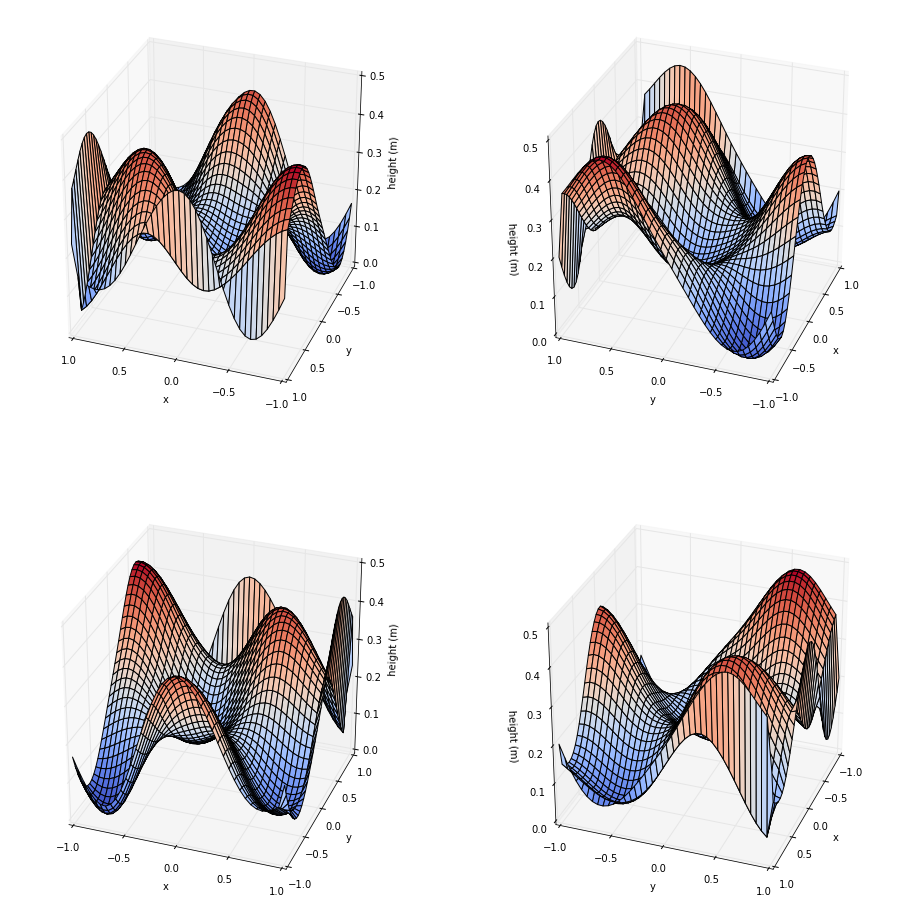

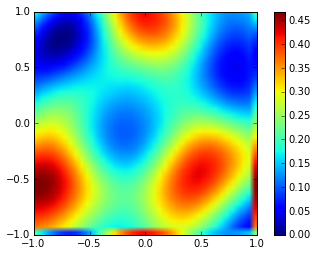

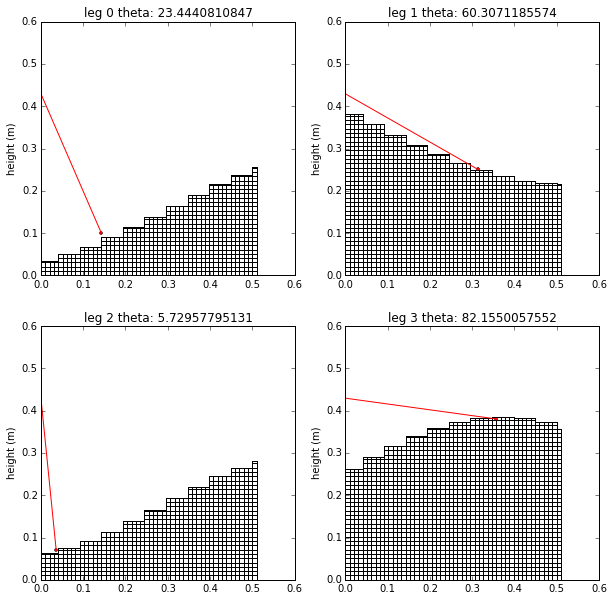

In [56]:
heightmap3d = create_map(octave=1, persistence=1, lacunarity=2, z_scale=0.25)
plot_3d_rand_map(heightmap3d)
plot_3d_rand_map_2d(heightmap3d)
heightmaps = get_terrain_heightmaps_1d(heightmap3d)
draw_legs_solution(heightmaps, eps=0.01)